In [48]:
from sklearn import linear_model
from typing import List, Tuple
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
DELIM = ","
PAIR_IDX = ("sample1", "sample2")
BLACK = "#4c566a"
BLUE = "#5e81ac"
XCOL = "x"
YCOL = "y"

In [49]:
def robust_regression(x: List[float], y: List[float]) -> List[float]:
    """Returns the prediction of the model. This prediction is used with X to plot
    line of best fit and get equation for that line.
    """
    X = [[v] for v in x]
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    pred = ransac.predict(X)
    return pred


def fit_model(
        x: List[float], y_pred: List[float]
) -> Tuple[float, float, float, float, float]:
    """Returns: gradient, intercept, r_value, p_value, std_err"""
    return stats.linregress(x, y_pred)

class AsymmetrixMatrixError(Exception):
    pass


def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.DataFrame:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx



In [50]:
compass_matrix = "../data/compass.matrix.csv"
bcftools_matrix = "../data/bcftools.matrix.csv"
map_matrix = "../data/pandora.map.matrix.csv"
compare_matrix = "../data/pandora.compare.matrix.csv"
pandora_mixed_matrix = "../data/mixed.pandora.matrix.csv"

In [51]:
# load the bcftools data
compass_df = load_matrix(compass_matrix, name=XCOL)
ont_df = load_matrix(bcftools_matrix, name=YCOL)
# merge the matrices
data = pd.concat([compass_df, ont_df], axis=1)
data["tool"] = "bcftools"
data = data.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)
# load the pandora data
ont_df = load_matrix(map_matrix, name=YCOL)
# merge the matrices
data2 = pd.concat([compass_df, ont_df], axis=1)
data2["tool"] = "pandora_single"
data2 = data2.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)
# load the pandora compare data
ont_df = load_matrix(compare_matrix, name=YCOL)
# merge the matrices
data3 = pd.concat([compass_df, ont_df], axis=1)
data3["tool"] = "pandora_multi"
data3 = data3.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)
data = pd.concat([data, data2, data3])

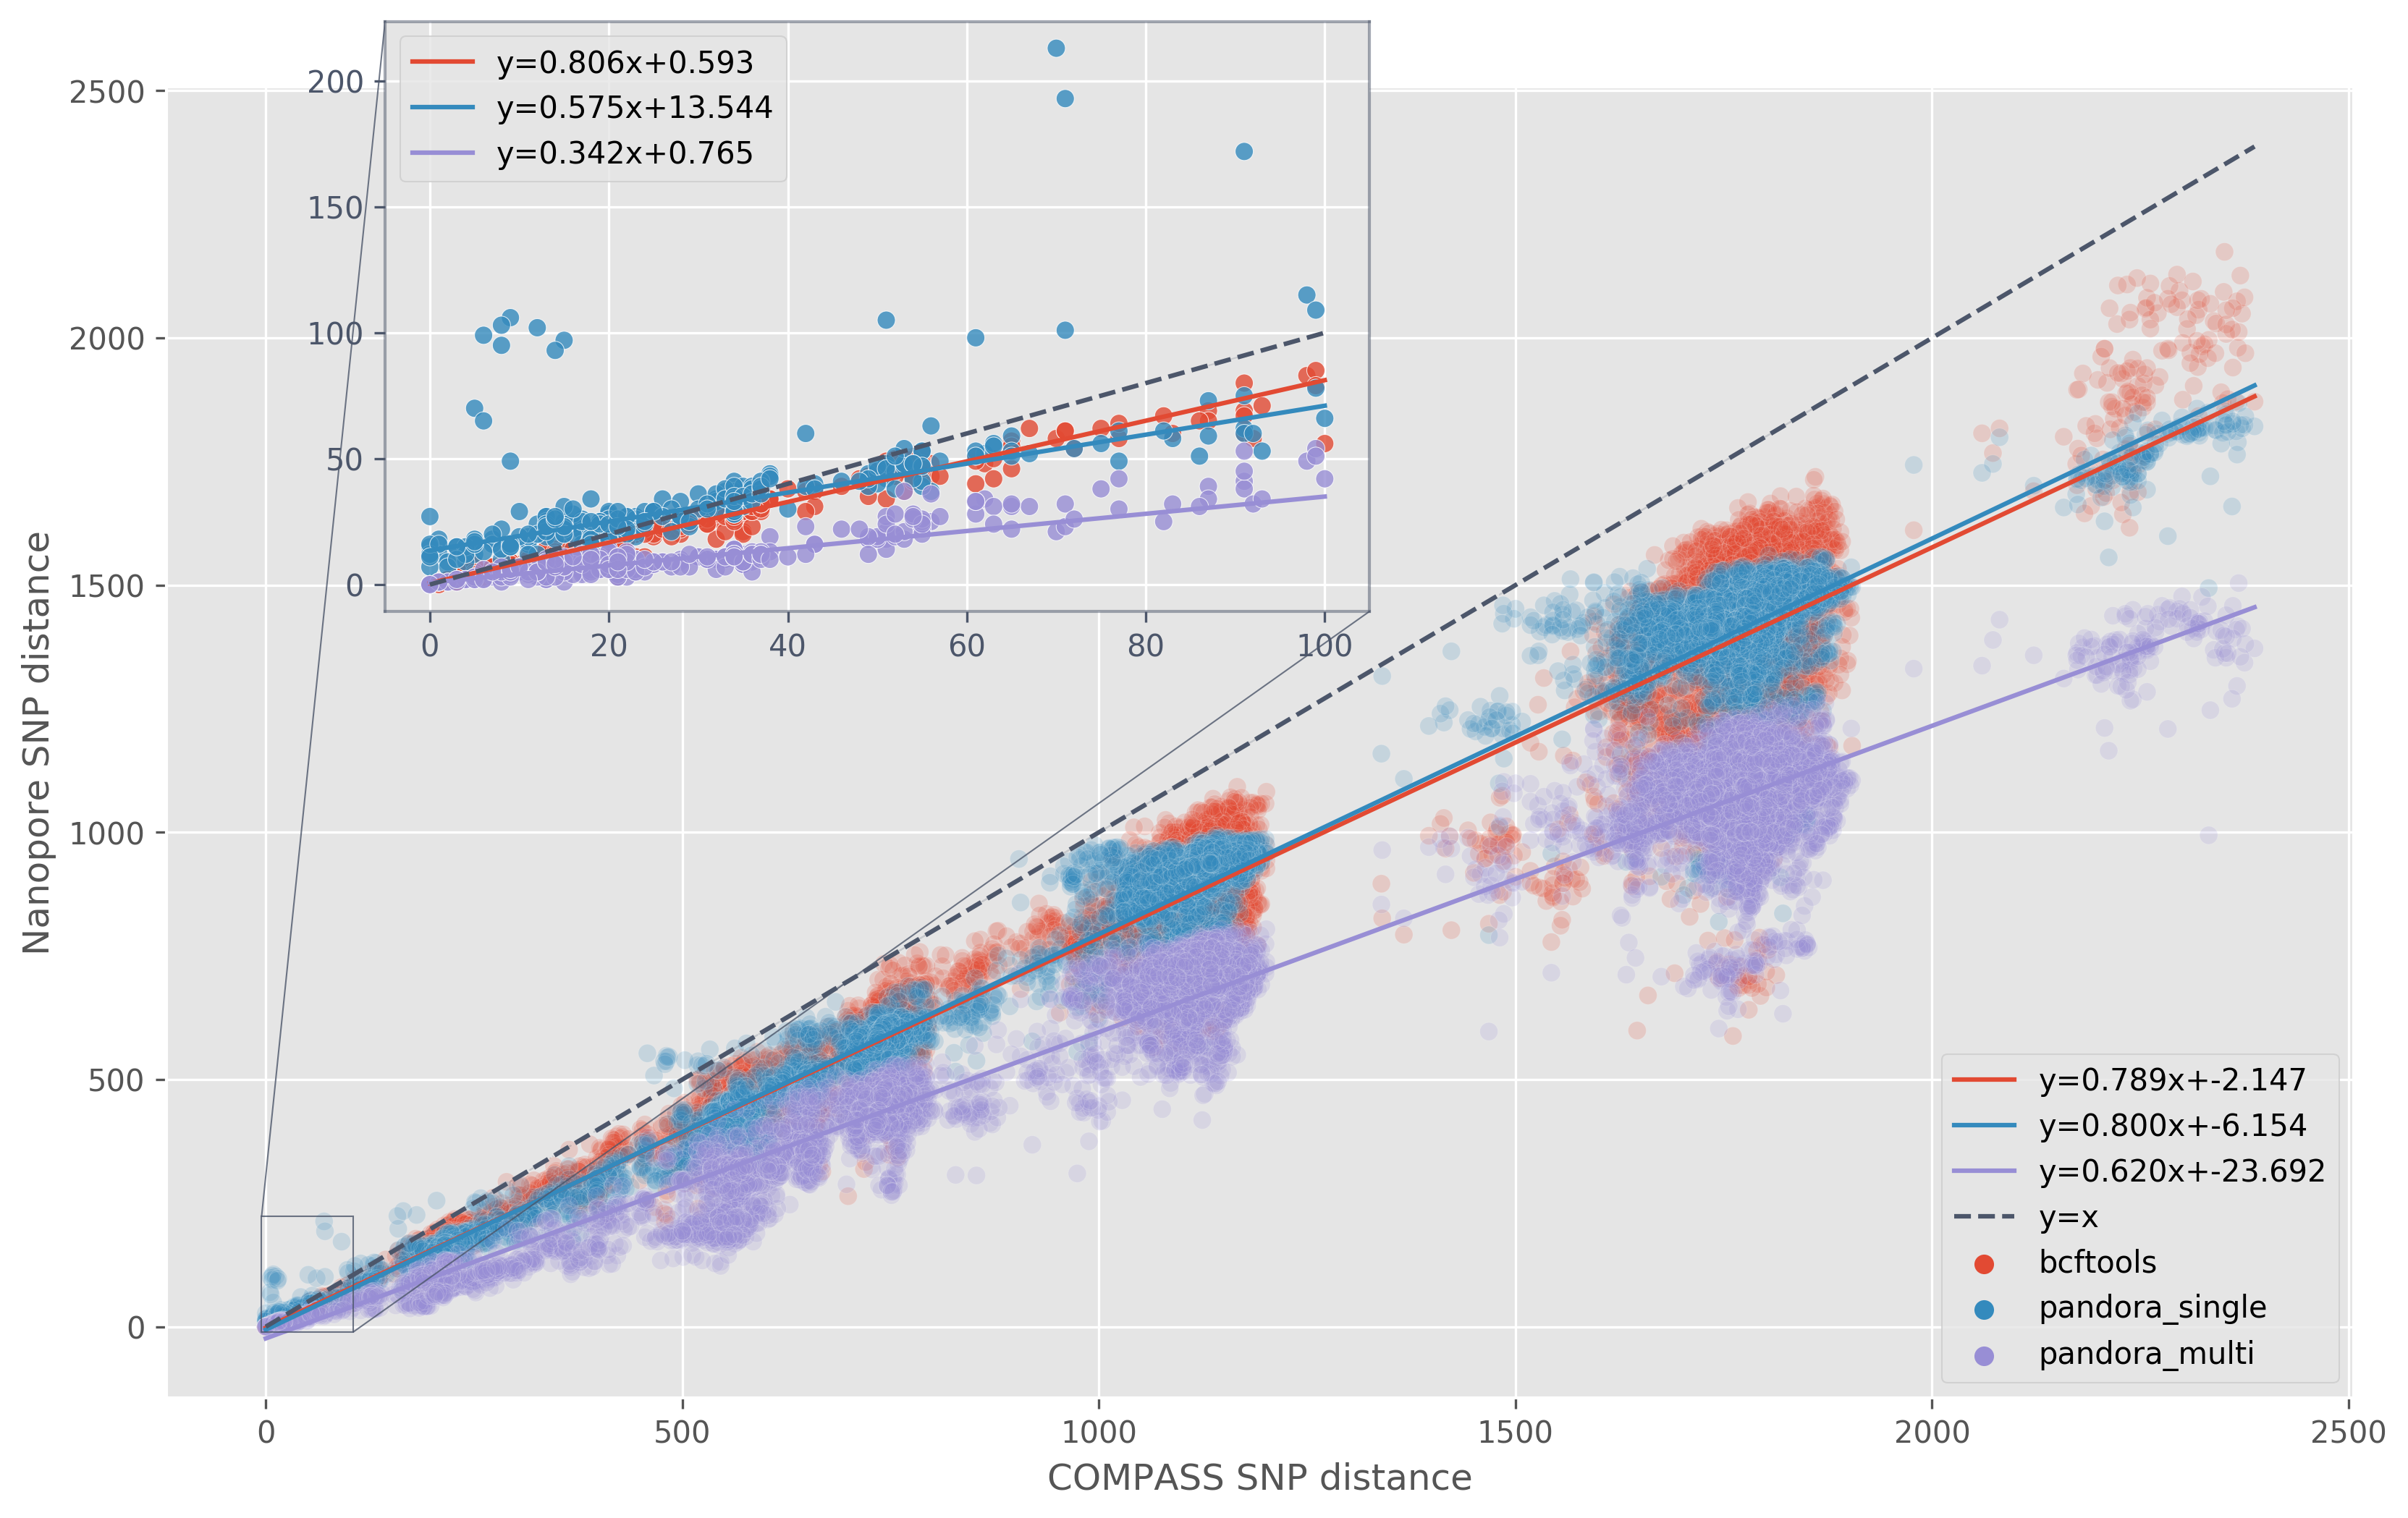

In [53]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
hue = "tool"
tools = ["bcftools", "pandora_single", "pandora_multi"]
# plot the full set of pairs
kwargs = dict(alpha=0.35, linewidth=0.25)
kwargs["alpha"] /= 2
sns.scatterplot(data=data, x=XCOL, y=YCOL, hue=hue, ax=ax, **kwargs)

# fit robust linear regressions
for tool in tools:
    d = data.query("tool==@tool")
    xs = d[XCOL]
    ys = d[YCOL]
    y_pred = robust_regression(xs, ys)
    slope, intercept, *_ = fit_model(xs, y_pred)
    eq = f"y={slope:.3f}x+{intercept:.3f}"
    sns.lineplot(x=xs, y=y_pred, ax=ax, label=eq)


# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--")
ax.set_xlabel("COMPASS SNP distance")
ax.set_ylabel("Nanopore SNP distance")
ax.legend(loc="lower right")

# set the lower left corner of the zoom inset (x0, y0, width, height)
axins = ax.inset_axes(bounds=[0.1, 0.6, 0.45, 0.45])
# sub region of the original image
threshold = 100
inset_data = data.query(f"{XCOL} <= @threshold")
kwargs["alpha"] = 0.8
axins = sns.scatterplot(data=inset_data, x=XCOL, y=YCOL, hue=hue, ax=axins, **kwargs)

# plot line of best fit as defined by the model
# fit robust linear regressions
for tool in tools:
    d = inset_data.query("tool==@tool")
    xs = d[XCOL]
    ys = d[YCOL]
    y_pred = robust_regression(xs, ys)
    slope, intercept, *_ = fit_model(xs, y_pred)
    eq = f"y={slope:.3f}x+{intercept:.3f}"
    sns.lineplot(x=xs, y=y_pred, ax=axins, label=eq)

# plot identity line
sns.lineplot(x=xs, y=xs, ax=axins, label="y=x", color=BLACK, linestyle="--")

# set the inset axis limits
axins.set_xlim(auto=True)
axins.set_ylim(auto=True)

# remove axis labels on inset
axins.set_xlabel("")
axins.set_ylabel("")

# styling of the inset zoom lines
ax.indicate_inset_zoom(axins, alpha=0.8, edgecolor=BLACK)
axins.tick_params(color=BLACK, labelcolor=BLACK)
# add a border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor(BLACK)
    spine.set_alpha(0.5)

# only output the line equations in the inset legend
handles, labels = axins.get_legend_handles_labels()
axins.legend(handles[:len(tools)], labels[:len(tools)], loc="upper left")


In [54]:
fig.savefig("/home/michael/Documents/phd/thesis/Chapter2/Figs/combined-dotplots.png")

In [44]:


def robust_regression(x: List[float], y: List[float]) -> List[float]:
    """Returns the prediction of the model. This prediction is used with X to plot
    line of best fit and get equation for that line.
    """
    X = [[v] for v in x]
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    pred = ransac.predict(X)
    return pred


def fit_model(
    x: List[float], y_pred: List[float]
) -> Tuple[float, float, float, float, float]:
    """Returns: gradient, intercept, r_value, p_value, std_err"""
    return stats.linregress(x, y_pred)


def load_matrix(fpath: str, delim: str = DELIM, name: str = "") -> pd.DataFrame:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    m = np.array(matrix)[idx]

    df = pd.DataFrame(m, columns=sorted_names, index=sorted_names)
    df = df.stack().rename(name).astype(int)
    df = df.rename_axis(PAIR_IDX)
    # remove the diagonal of the matrix
    ix = [x != y for (x, y) in df.index]
    df = df[ix]
    return df




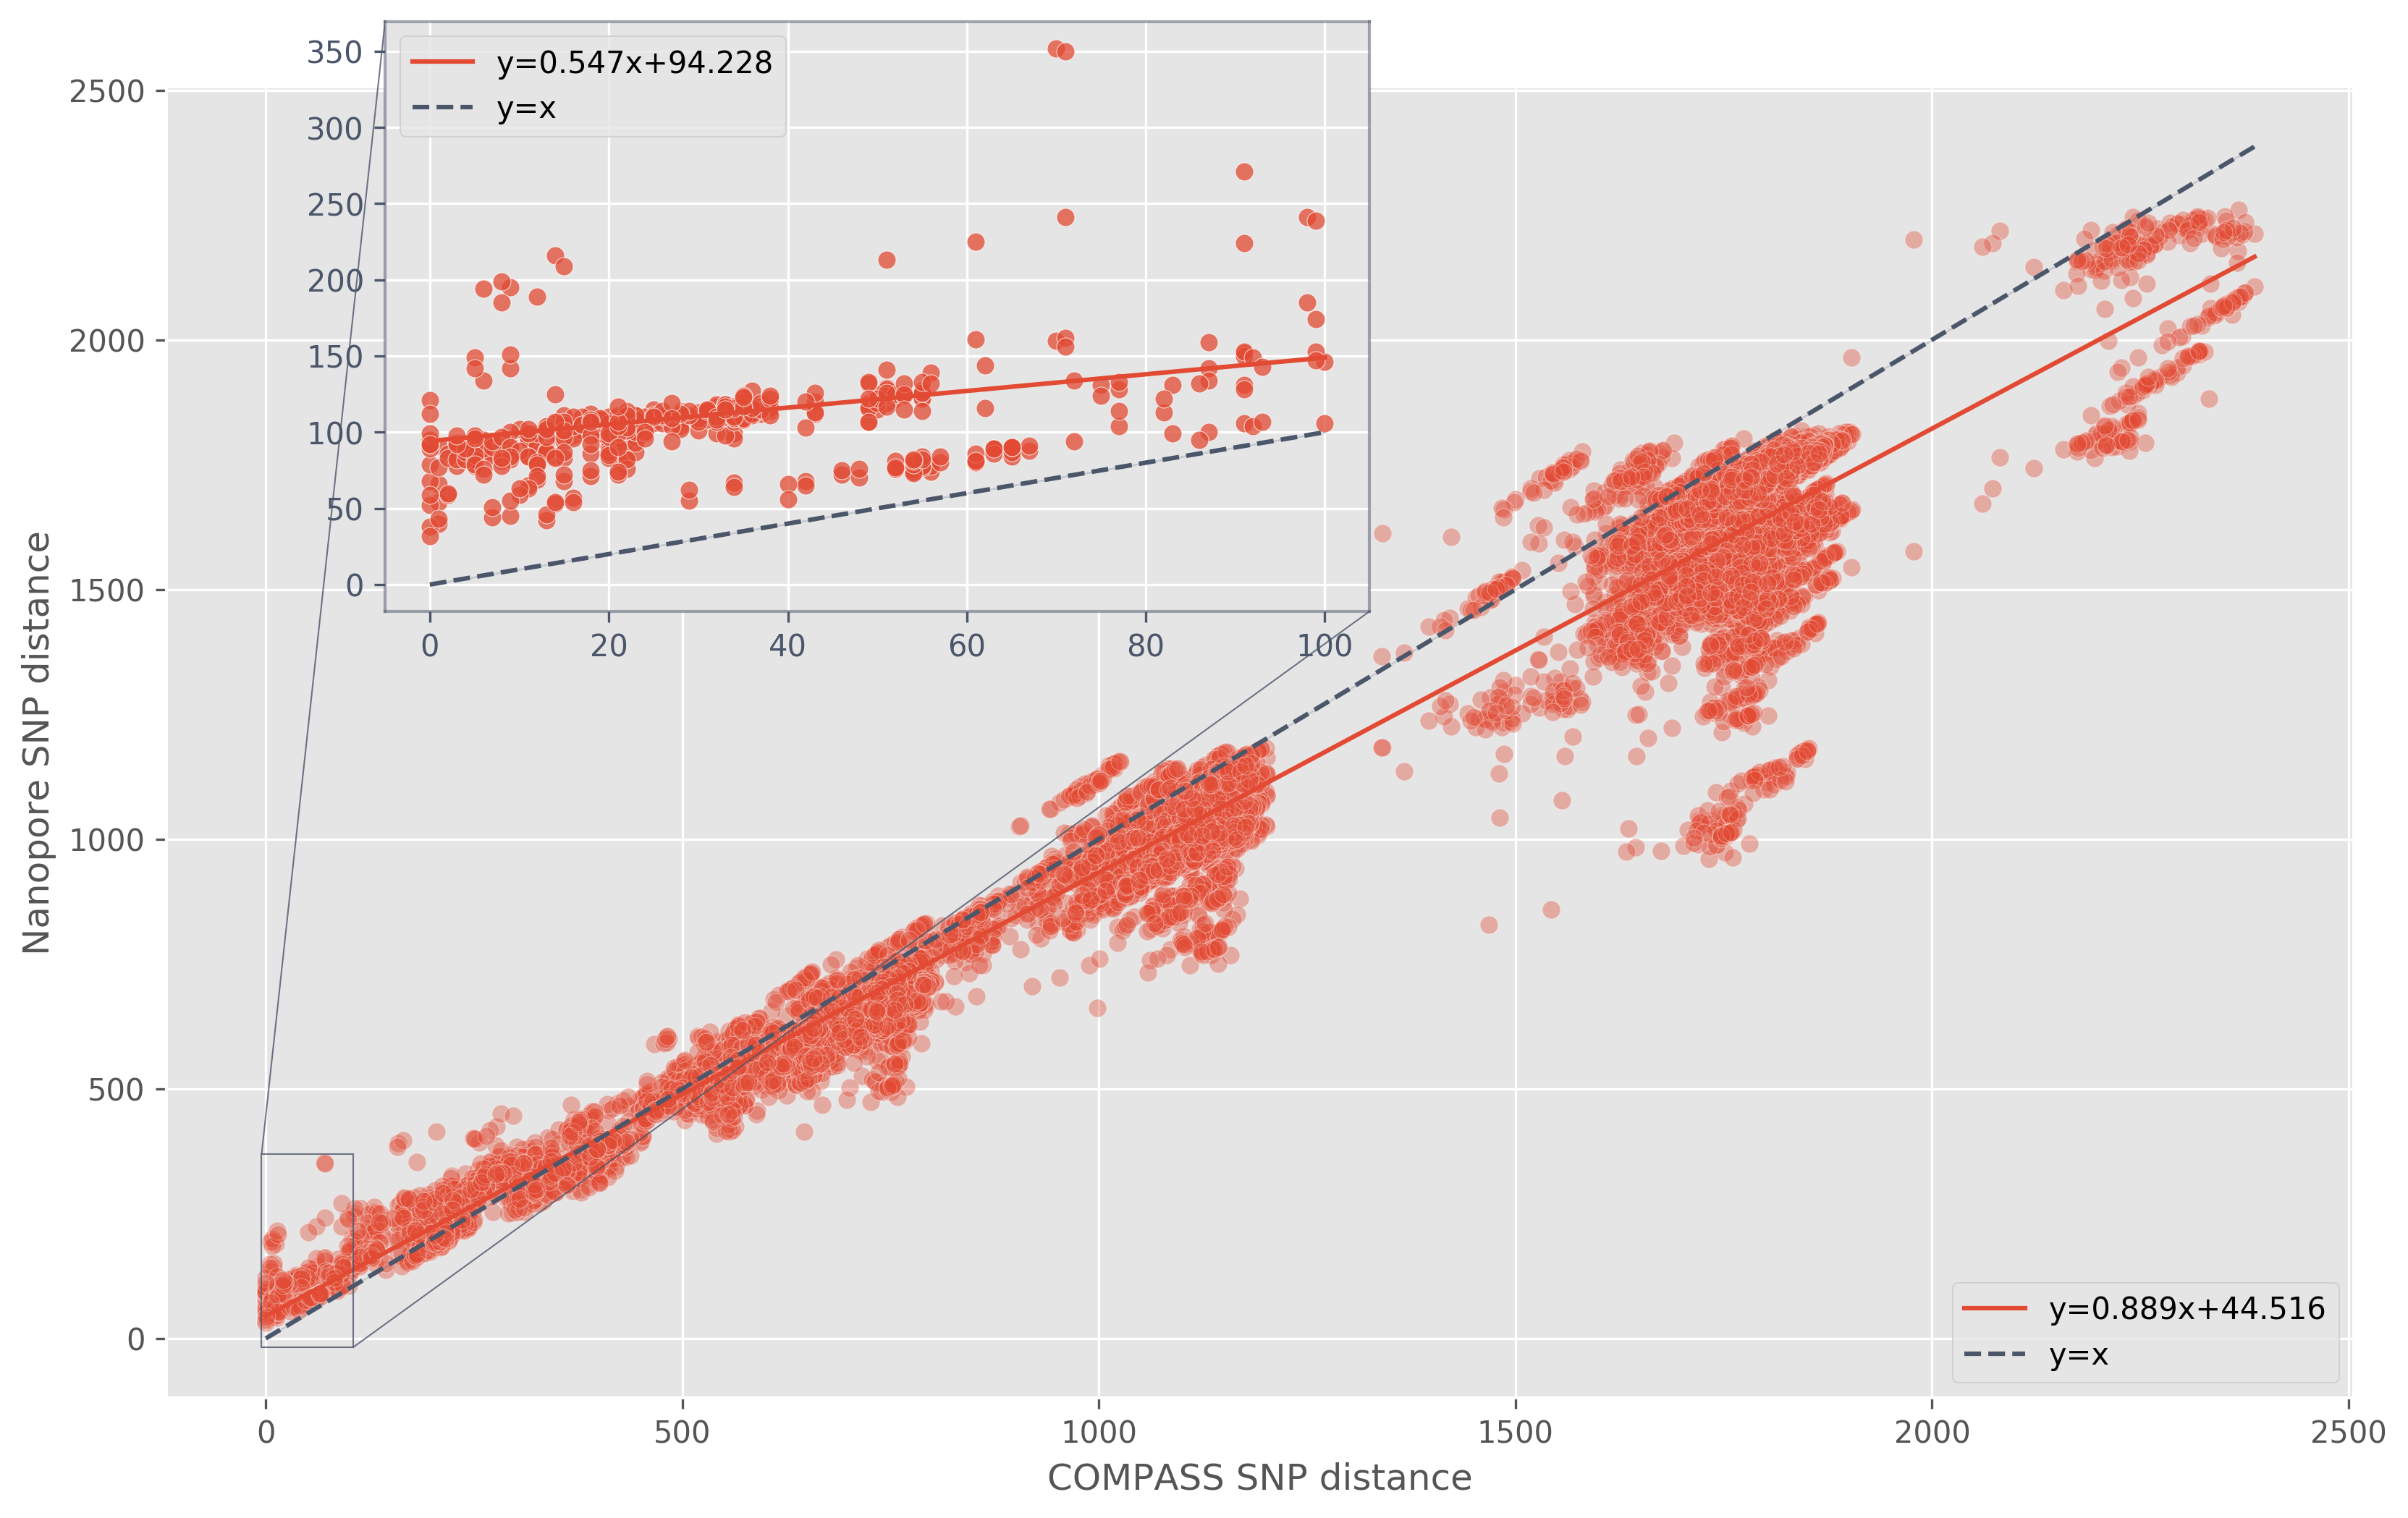

In [47]:
# load the data
compass_df = load_matrix(compass_matrix, name=XCOL)
mixed_df = load_matrix(pandora_mixed_matrix, name=YCOL)
# merge the matrices
data = pd.concat([compass_df, mixed_df], axis=1)
data = data.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)

fig, ax = plt.subplots(figsize=(13, 8), dpi=300)

# plot the full set of pairs
kwargs = dict(alpha=0.75, linewidth=0.25)
kwargs["alpha"] /= 2
sns.scatterplot(data=data, x=XCOL, y=YCOL, ax=ax, **kwargs)

# fit robust linear regressions
xs = data[XCOL]
ys = data[YCOL]
y_pred = robust_regression(xs, ys)
slope, intercept, *_ = fit_model(xs, y_pred)
eq = f"y={slope:.3f}x+{intercept:.3f}"
sns.lineplot(x=xs, y=y_pred, ax=ax, label=eq)


# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--")
ax.set_xlabel("COMPASS SNP distance")
ax.set_ylabel("Nanopore SNP distance")
ax.legend(loc="lower right")

# set the lower left corner of the zoom inset (x0, y0, width, height)
axins = ax.inset_axes(bounds=[0.1, 0.6, 0.45, 0.45])
# sub region of the original image
threshold = 100
inset_data = data.query(f"{XCOL} <= @threshold")
kwargs["alpha"] *= 2
axins = sns.scatterplot(data=inset_data, x=XCOL, y=YCOL, ax=axins, **kwargs)

# plot line of best fit as defined by the model
# fit robust linear regressions
xs = inset_data[XCOL]
ys = inset_data[YCOL]
y_pred = robust_regression(xs, ys)
slope, intercept, *_ = fit_model(xs, y_pred)
eq = f"y={slope:.3f}x+{intercept:.3f}"
sns.lineplot(x=xs, y=y_pred, ax=axins, label=eq)

# plot identity line
sns.lineplot(x=xs, y=xs, ax=axins, label="y=x", color=BLACK, linestyle="--")

# set the inset axis limits
axins.set_xlim(auto=True)
axins.set_ylim(auto=True)

# remove axis labels on inset
axins.set_xlabel("")
axins.set_ylabel("")

# styling of the inset zoom lines
ax.indicate_inset_zoom(axins, alpha=0.8, edgecolor=BLACK)
axins.tick_params(color=BLACK, labelcolor=BLACK)
# add a border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor(BLACK)
    spine.set_alpha(0.5)

axins.legend(loc="upper left")